<a href="https://colab.research.google.com/github/Osdel/ssnets/blob/master/Iris_Segmentation_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to Cubiris Iris Segmentation Tutorial
In this example you will learn how to use deep learning on semantic segmentation. We are going to use multiple iris recognition datasets.

An iris recognition pipeline is well known for use (but not necessary) this following steps:
* Image Acquisition
* Image Preprocessing (Iris Segmentation, Iris Normalization, etc)
* Feature Extraction
* Matching

![Iris Recognition Pipeline](https://www.researchgate.net/profile/Arun_Ross/publication/224597357/figure/fig1/AS:393889732153344@1470922038035/Block-diagram-of-an-iris-recognition-system.png "Pipeline")

Iris Segmentation is a key step in the iris recognition pipeline. If the iris is not properly detected then the entire pipeline is not going to work. In this example, we are going to try some deep learning architectures in order to get reasonable results to be able to go ahead with the recognition process.

Theres 2 types of iris images used by the scientific community:
* Infrared images
* Visible Wavelenght

In this tutorial we will learn how to train our models to get semantic segmentation state-of-the-art result using visible wavelength iris images in non-cooperative enviroments.

First, let's get the training data. The training data contains:
* Train images from [Nice-I](http://nice1.di.ubi.pt/) dataset 
* Train images from [Nice-II](http://nice2.di.ubi.pt/) dataset
* Train images from [MobBio](https://paginas.fe.up.pt/~mobbio2013/) dataset

We merged all 3 train dataset to get more images and different iris images distributions. We got a total of 2281 images, but don't worry we also gonna augment them using Data Augmentation.

First, let's download our data. If the script below does not work for you, use this [link](https://drive.google.com/file/d/1m19qRbHia03MTB5KzW7roGbv8G6kS6NV/view?usp=sharing)


In [0]:
#!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1m19qRbHia03MTB5KzW7roGbv8G6kS6NV',
                                    dest_path='./data.rar',showsize=True,overwrite=True)


Once you get the rar file, extract it!

In [0]:
!unrar x data.rar

### Importing the main libraries
We are gonna use tensorflow.keras framework version 1.15, mostly because Google Collab don't support (at this time) Tensorflow 2.0

In [0]:
import tensorflow as tf
import numpy as np
import pickle
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input,Lambda
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from matplotlib import pyplot as plt
%matplotlib inline

import os
!git clone https://github.com/Osdel/ssnets.git
os.chdir('ssnets')
#local dependencies
from fcn8 import build_model as build_fcn
from fc_densenet import build_fc_densenet
#in order to use unet_mobilenet we need to use pix2pix network
!pip install -q git+https://github.com/tensorflow/examples.git
from unet_mobilenet import unet_model as build_mobilnet_unet
os.chdir('..')

Cloning into 'ssnets'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 92 (delta 27), reused 31 (delta 10), pack-reused 30
Unpacking objects: 100% (92/92), done.


In [0]:
!nvidia-smi

Sun May 17 19:25:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Defining local variables
Let's define some local variables:
* Paths to datasets
* Target size of images
* Batch Size

In [0]:
img_path = 'iris_datasets/Train/img'
mask_path = 'iris_datasets/Train/mask'

val_img_path = 'iris_datasets/Val/combined/img'
val_mask_path = 'iris_datasets/Val/combined/mask'

nice1_val_img = 'iris_datasets/Val/NICE1/img'
nice1_val_mask = 'iris_datasets/Val/NICE1/mask'

nice2_val_img = 'iris_datasets/Val/NICE2/img'
nice2_val_mask = 'iris_datasets/Val/NICE2/mask'

target_size = (224,224)
batch_size = 16

The function below zero-center the data using Imagenet mean. This is useful because the FCN8 (Fully Convolutional Network) model which we are gonna build later uses a Imagenet-pretrained model. The function reverse_zero_centering restore the original image.

In [0]:
#imagenet zero-center
mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,3))
def prep_images(x,mean=mean):
    rgb = x.astype('uint8')-mean
    return rgb
    
def reverse_zero_centering(x,mean=mean):
    return (x+mean).astype('uint8')

### Data Generators
Keras has a really easy-to-use tool to load image datasets and perform data augmentation named ImageDataGenerator. But, keep in mind that this is slower than using Tensorflow dataset API.

In order to get both images and masks, we need to create two generators and zip them into one. You can get more information about Data Generators at [Keras Documentation](https://keras.io/preprocessing/image/).

In our case, we have sparse labels for masks. That means that our mask contains the class index for each pixel instead of one-hot encoding labels. In this example, where we have only 2 classes, it's not a big deal, but in dataset with a lot of classes, getting one-hot labels consume a lot of memory and runtime performance.

We are using rotations, shiftings, and zooming for data augmentation. This may help to prevent overfitting, allowing the networks to generalize better. Feel free to play with the values :)

In [0]:
# we create two instances with the same arguments
data_gen_args = dict(rotation_range=45,width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.2)
image_datagen = ImageDataGenerator(**data_gen_args,fill_mode='constant',cval=0, preprocessing_function=prep_images)
mask_datagen = ImageDataGenerator(**data_gen_args,fill_mode='constant',cval=0,dtype='uint8',preprocessing_function=lambda x: x.astype('uint8'))

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_generator = image_datagen.flow_from_directory(
    img_path,
    class_mode=None,
    batch_size=batch_size,
    seed=seed,
    target_size=target_size
    )

mask_generator = mask_datagen.flow_from_directory(
    mask_path,
    class_mode=None,
    seed=seed,
    batch_size=batch_size,
    target_size=target_size,
    color_mode='grayscale'
    )
train_samples = image_generator.samples
# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

Found 2281 images belonging to 1 classes.
Found 2281 images belonging to 1 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:173: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


In [0]:
def display_data_samples(data_gen,samples=5,reverse_prep_fn=reverse_zero_centering):
  count = 0
  for img,mask in data_gen:
    if count>=samples:
      break
    rgb_img = img[0] if reverse_prep_fn is None else reverse_prep_fn(img)[0]
    bin_mask = np.repeat(mask[0],3,axis=-1).astype('uint8')
    mosaic = np.hstack((rgb_img,bin_mask*255,rgb_img*bin_mask))
    plt.figure()
    plt.imshow(mosaic)
    count+=1

Let's take a look how the data has been augmented.

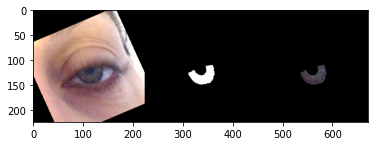

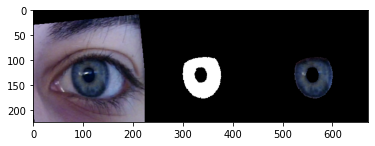

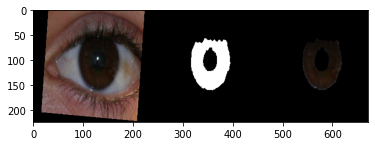

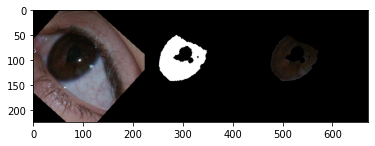

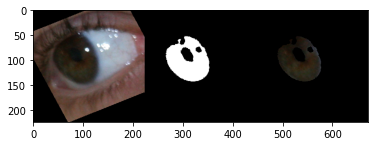

In [0]:
display_data_samples(train_generator,5)

## Validation Dataset
Let's create our validation dataset. The validation step is extremely important to evaluate how the model is learning. If the training error decrease but the validation don't that means that our model is overfitting our training data.

Note that now, we don't use any kind of data augmentation. Also, in order to compare our results with state of the art models we are going to load NICE-I and NICE-II together and separately.

### NICE Dataset
The dataset (loaded below) combines NICE-I and NICE-II validation images and masks.

In [0]:
data_gen_args = dict()
val_image_datagen = ImageDataGenerator(**data_gen_args,fill_mode='constant',cval=0, preprocessing_function=prep_images)
val_mask_datagen = ImageDataGenerator(**data_gen_args,fill_mode='constant',cval=0,dtype='uint8')

seed = 1
val_image_generator = val_image_datagen.flow_from_directory(
    val_img_path,
    class_mode=None,
    batch_size=1,
    seed=seed,
    target_size=target_size
    )

val_mask_generator = val_mask_datagen.flow_from_directory(
    val_mask_path,
    class_mode=None,
    seed=seed,
    batch_size=1,
    target_size=target_size,
    color_mode='grayscale'
    )
#getting the number of samples of the dataset
val_samples = val_image_generator.samples

# combine generators into one which yields image and masks
val_generator = zip(val_image_generator, val_mask_generator)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:173: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.


Let's take a look into the validation images:

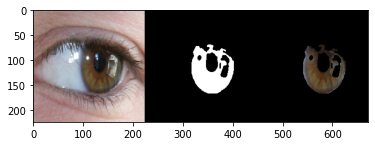

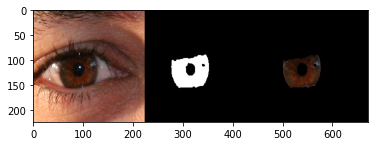

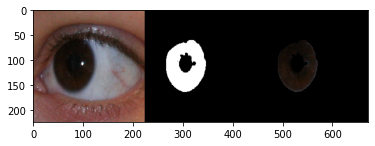

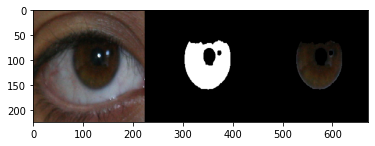

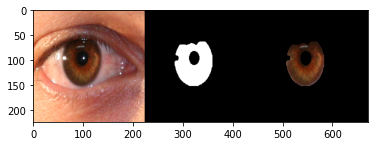

In [0]:
display_data_samples(val_generator,5)

### Now lets load NICE-I and NICE-II datasets separately

In [0]:
data_gen_args = dict()
nice1_image_datagen = ImageDataGenerator(**data_gen_args, preprocessing_function=prep_images)
nice1_mask_datagen = ImageDataGenerator(**data_gen_args,dtype='uint8')

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
nice1_image_generator = nice1_image_datagen.flow_from_directory(
    nice1_val_img,
    class_mode=None,
    batch_size=1,
    seed=seed,
    target_size=target_size,
    shuffle = False
    )

nice1_mask_generator = nice1_mask_datagen.flow_from_directory(
    nice1_val_mask,
    class_mode=None,
    seed=seed,
    batch_size=1,
    target_size=target_size,
    color_mode='grayscale',
    shuffle=False
    )
nice1_samples = nice1_image_generator.samples
# combine generators into one which yields image and masks
nice1_generator = zip(nice1_image_generator, nice1_mask_generator)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:173: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 445 images belonging to 1 classes.
Found 445 images belonging to 1 classes.


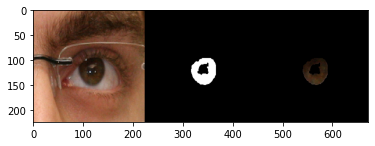

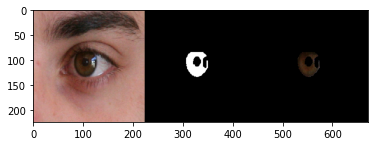

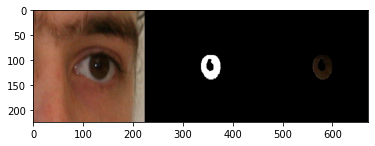

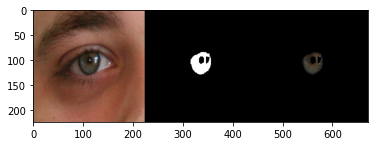

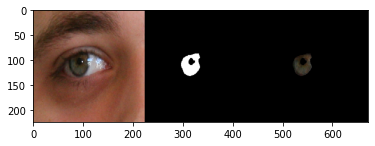

In [0]:
display_data_samples(nice1_generator)

In [0]:
data_gen_args = dict()
nice2_image_datagen = ImageDataGenerator(**data_gen_args, preprocessing_function=prep_images)
nice2_mask_datagen = ImageDataGenerator(**data_gen_args,dtype='uint8')

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
nice2_image_generator = nice2_image_datagen.flow_from_directory(
    nice2_val_img,
    class_mode=None,
    batch_size=1,
    seed=seed,
    target_size=target_size,
    shuffle = False
    )

nice2_mask_generator = nice2_mask_datagen.flow_from_directory(
    nice2_val_mask,
    class_mode=None,
    seed=seed,
    batch_size=1,
    target_size=target_size,
    color_mode='grayscale',
    shuffle=False
    )
nice2_samples = nice1_image_generator.samples
# combine generators into one which yields image and masks
nice2_generator = zip(nice2_image_generator, nice2_mask_generator)

Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:173: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


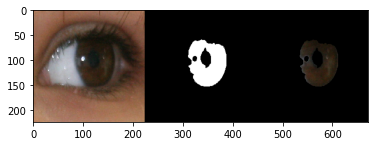

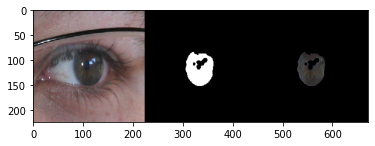

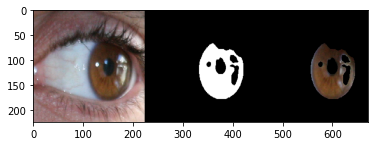

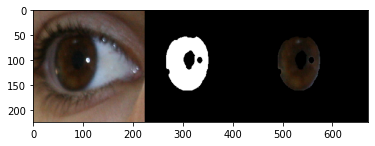

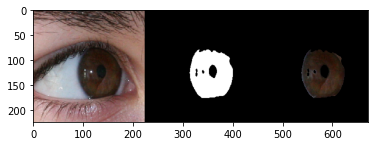

In [0]:
display_data_samples(nice2_generator)

## Metrics
In order to evaluate the performance of our models we need some metrics. At first glance, it might be difficult to see the issue with the accuracy (percent of pixels in your image that are classified correctly). To expose this metric for what it really is I suggest you to read [this](https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2) great explanation. The Accuracy and IOU (Intersection over Union) are provided by Tensorflow. In the case of IOU we don't use exactly the Tensorflow implementation because our models prediction are softmax logits and the ground-truth labels are sparse labels, so we create our own metric which inherit from Tensorflow IOU and transform logits into sparse categorical labels.

As evaluation metric we consider the E<sup>1</sup> evaluation measure proposed by the NICE-I protocol. This is going to allow us to compare our algorith with state-of-the-art models. This metric estimates the proportion of correspondent disagreeing pixels as follow:

![equation](http://nice1.di.ubi.pt/eq1.jpg)

We don't need to create a custom metric for this one, note that the E<sup>1</sup> metric is 1-accuracy. For more information, visit the offcial NICE-I website [here](http://nice1.di.ubi.pt/evaluation.htm).

In [0]:
class CategoricalIOU(tf.compat.v2.metrics.MeanIoU):
    def __init__(self,num_classes=2,thresholds=None,top_k=None,class_id=None,name='iou',dtype=None):
      self.num_classes = 2
      super(CategoricalIOU, self).__init__(num_classes=num_classes,name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
      y_pred = K.argmax(y_pred,axis=-1)
      super().update_state(y_true, y_pred, sample_weight)


Let's define our training variables.

In [0]:
epochs = 130
steps_per_epoch = train_samples/batch_size
buffer=10

## Models
Now let's take a look into the model's architectures we are going to try. Semantic Segmentation is a growing field which has been evolving so fast. I specially recommend to read this [survey](https://heartbeat.fritz.ai/a-2019-guide-to-semantic-segmentation-ca8242f5a7fc).

We are going to use, for the sake of this tutorial, some of the most basic models:
* FCN - Fully Convolutional Networks (https://arxiv.org/abs/1605.06211)
* U-Net (https://arxiv.org/abs/1505.04597)

Note that we also provide a FastFCN Model which is the same FCN model but using Depthwise Separable Convolutions. **This model IS NOT the FastFCN model of this [paper](https://paperswithcode.com/paper/fastfcn-rethinking-dilated-convolution-in-the)**.

The U-Net model uses a MobileNet-V2 as Backbone, the source code was taken from Tensorflow Documentation (https://www.tensorflow.org/tutorials/images/segmentation).

Let's start with FCN8:



In [0]:
fcn8 = build_fcn(*target_size,1+1,conv_type='conv',l2_reg=2e-5)
fcn8.summary()

Now the FCN8 using Depthwise Separable Convolution:

In [0]:
fast_fcn8 = build_fcn(*target_size,1+1,conv_type='ds',l2_reg=25e-5)
fast_fcn8.summary()

As you can see there's a difference of 124M-20M=114M of trainable parameters. That's A LOT if we considered that is the same model, just changing standard convolution for DS convolutions. But, what about performance? Is this memory reduction worth?

Let's compile our models. We are using Adam Optimizer with learning rate of 0.0004. Feel free to play with the values, or use other optimizer such as SGD or RMSProp.

In [0]:
fcn8.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy,CategoricalIOU(2)])

In [0]:
fast_fcn8.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy,CategoricalIOU(2)])

Note that we are using the sparse_categorical_accuracy and sparse_categorical_crossentropy because we use sparse labels. Also, we use l2 regularization to reduce overfitting (l2_reg parameter in the model construction).

To avoid keras error when passing a ImageDataGenerator to model.fit we need to use this trick. This won't be a issue on Tensorflow 2.0.

In [0]:
val_generator = (pair for pair in val_generator)
nice1_generator = (pair for pair in nice1_generator)
nice2_generator = (pair for pair in nice2_generator)
train_generator = (pair for pair in train_generator)

Comment these blocks or don't run them if you don't want to train FCN8. I recommend to just train FastFCN8, as you will se in this example the performance is similar and FastFCN is faster and smaller.

In [0]:
#this can take a while....Zzzzz...
fcn_history = fcn8.fit(train_generator, epochs=epochs,verbose=0, steps_per_epoch=steps_per_epoch,\
        validation_data=val_generator, validation_steps=val_samples,
        max_queue_size=buffer, workers=1, use_multiprocessing=False)

In [0]:
fastfcn_history = fast_fcn8.fit(train_generator, epochs=epochs,verbose=0, steps_per_epoch=steps_per_epoch,\
        validation_data=val_generator, validation_steps=val_samples,
        max_queue_size=buffer, workers=1, use_multiprocessing=False)

## Evaluation
It's time to see how our models performed. First, let's define some helper functions.

In [0]:
def display_prediction(generator,model,k,reverse_fn=None):
  for _ in range(k):
    x0,y0 = next(generator)
    pred = np.expand_dims(np.argmax(model.predict(x0),axis=-1),-1)
    if reverse_fn is not None:
      x0 = reverse_fn(x0)
    mosaic = np.hstack((x0[0],\
                        np.repeat(y0[0]*255,3,axis=-1),\
                        np.repeat(pred[0]*255,3,axis=-1))).astype('uint8')
    plt.figure()
    plt.imshow(mosaic)

In [0]:
def eval(model):
  val_res = model.evaluate_generator(val_generator,steps=val_samples)
  nice1_res = model.evaluate_generator(nice1_generator,steps=nice1_samples)
  nice2_res = model.evaluate_generator(nice2_generator,steps=nice2_samples)
  print('Combined',val_res)
  print('NICE-I',nice1_res)
  print('NICE-II',nice2_res)
  return val_res,nice1_res,nice2_res

In [0]:
def plot_curves(model_history,model_name):
  plt.plot(model_history.history['sparse_categorical_accuracy'])
  plt.plot(model_history.history['val_sparse_categorical_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend([model_name+' Train', model_name+' Val'], loc='lower right')
  plt.figure()
  plt.show()

  #loss values
  plt.plot(model_history.history['loss'])
  plt.plot(model_history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend([model_name+' Train', model_name+' Val'], loc='upper right')
  plt.figure()
  plt.show()

  #loss values
  plt.plot(model_history.history['iou'])
  plt.plot(model_history.history['val_iou'])
  plt.title('Model IOU')
  plt.ylabel('IOU')
  plt.xlabel('Epoch')
  plt.legend([model_name+' Train', model_name+' Val'], loc='lower right')
  plt.figure()
  plt.show()

The following function allow us to add regularization to a model. The Unet-Mobilenet model we are gonna build later doesn't uses regulazation, so this method is gonna be useful.

In [0]:
import tempfile
def add_regularization(model, lr=2e-5):
    regularizer=tf.keras.regularizers.l2(lr)

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

We are ready to evaluate our FCNs models. Lets take a look to the loss, accuracy and IO curves first.

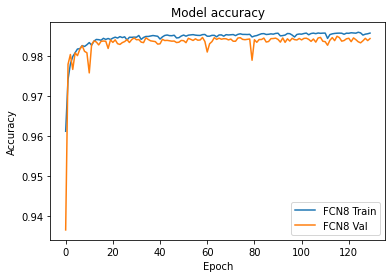

<Figure size 432x288 with 0 Axes>

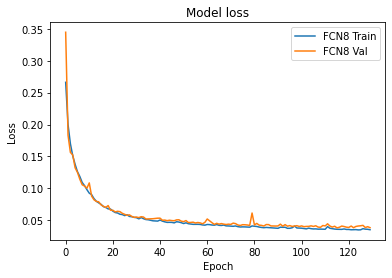

<Figure size 432x288 with 0 Axes>

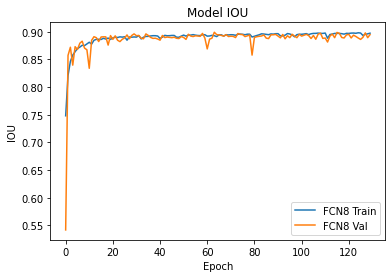

<Figure size 432x288 with 0 Axes>

In [0]:
plot_curves(fcn_history,'FCN8')

As you can see both train and validation losses, accuracy and IOU improve together smoothly over time (epochs) wich indicates the models is learning properly. But let's see the numbers:

In [0]:
eval(fcn8)

Combined [0.038704995065927505, 0.9843763709068298, 0.8944653272628784]
NICE-I [0.037661291658878326, 0.9847284555435181, 0.8734114170074463]
NICE-II [0.03797629103064537, 0.9846523404121399, 0.8934252262115479]


([0.038704995065927505, 0.9843763709068298, 0.8944653272628784],
 [0.037661291658878326, 0.9847284555435181, 0.8734114170074463],
 [0.03797629103064537, 0.9846523404121399, 0.8934252262115479])

Our validation accuracy was about 98.44% and IOU 89.45 which is really good to be our first run. Now let's see some predictions, feel free to change the number of samples to get a better analysis of the segmentations

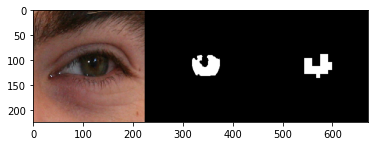

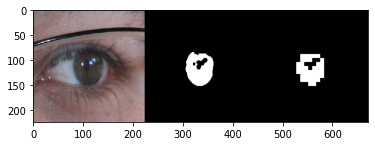

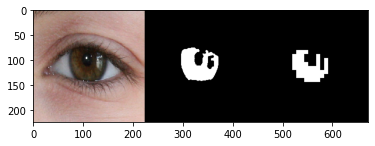

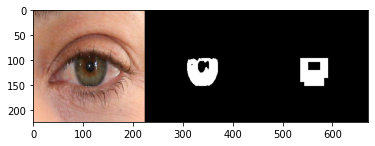

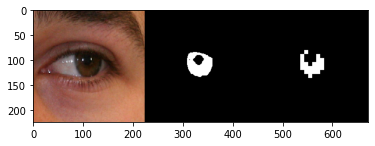

In [0]:
display_prediction(val_generator,fcn8,5,reverse_zero_centering)

Now let's do the same with FastFCN8 and comrpare them:

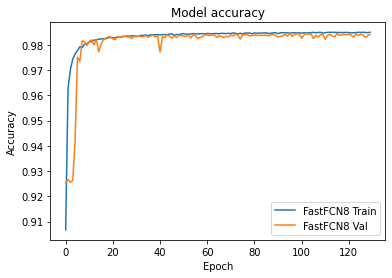

<Figure size 432x288 with 0 Axes>

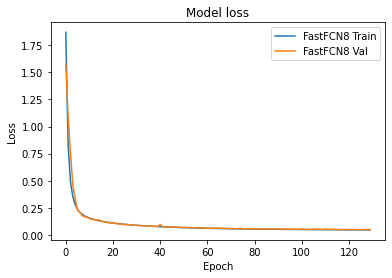

<Figure size 432x288 with 0 Axes>

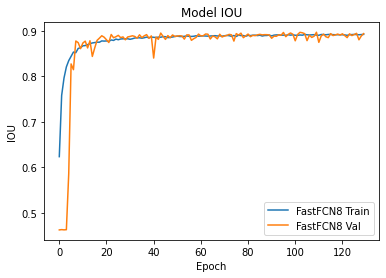

<Figure size 432x288 with 0 Axes>

In [0]:
plot_curves(fastfcn_history,'FastFCN8')

In [0]:
eval(fast_fcn8)

Combined [0.04685498774051666, 0.9842584729194641, 0.8917965888977051]
NICE-I [0.04608593136072159, 0.9845926761627197, 0.8727661371231079]
NICE-II [0.04728884622454643, 0.9840147495269775, 0.892302393913269]


([0.04685498774051666, 0.9842584729194641, 0.8917965888977051],
 [0.04608593136072159, 0.9845926761627197, 0.8727661371231079],
 [0.04728884622454643, 0.9840147495269775, 0.892302393913269])

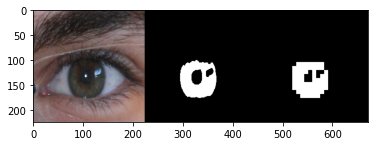

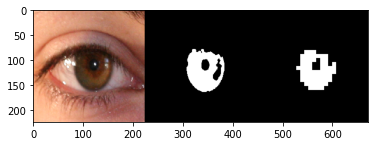

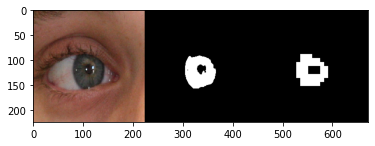

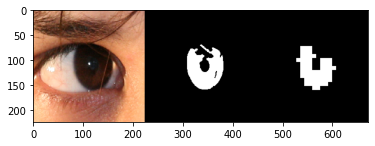

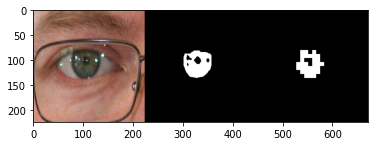

In [0]:
display_prediction(val_generator,fast_fcn8,5,reverse_zero_centering)

Both models achieved similar results. Adding Depthwise Separable Convolutions to our model not just reduced the memory usage drastically but also kept the same learning power.

Now let's try with Unet model. This time using MobileNet as backbone.

## U-Net
As mentioned above, we are going to use a MobileNet as Encoder and then Pix2Pix to upsample.


In [0]:
mobinet_unet = build_mobilnet_unet(1+1,*target_size)

9412608/9406464 [==============================] - 0s 0us/step


Because we are using MobileNet from tf.keras.applications implementation, we need to add regularization using the function we created before.

In [0]:
mobinet_unet= add_regularization(mobinet_unet,25e-5)
mobinet_unet.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=1e-4),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy,CategoricalIOU(2)])

In the case of MobileNet we have to change the way we preprocess images. Instead of zero-center the data using the Imagenet mean we are going to use the tensorflow normalization method for MobileNet-V2, as well as the reversing function to reconstruct the original image. This is gonna allow the model to use the pretrained weights properly.

In [0]:
def prep_mobilenet(x):
  return tf.keras.applications.mobilenet_v2.preprocess_input(x)

def reverse_mobilenet_prep(x):
  """keras preprocessing does the follow:
    x /= 127.5
    x -= 1.
    Let's reverse it!
  """
  x+=1.
  x*=127.5
  return x

Now, let's update the generators using the new preprocessing function.

In [0]:
image_datagen.preprocessing_function = prep_mobilenet
val_image_datagen.preprocessing_function = prep_mobilenet
nice1_image_datagen.preprocessing_function = prep_mobilenet
nice2_image_datagen.preprocessing_function = prep_mobilenet

We have everything ready, now it's time to train. Feel free to change the training parameters declared above if you want to tune something else.

In [0]:
unet_mobilenet_history = mobinet_unet.fit_generator(train_generator, epochs=epochs,verbose=0, steps_per_epoch=steps_per_epoch,\
        validation_data=val_generator, validation_steps=val_samples,
        max_queue_size=buffer, workers=1, use_multiprocessing=False)

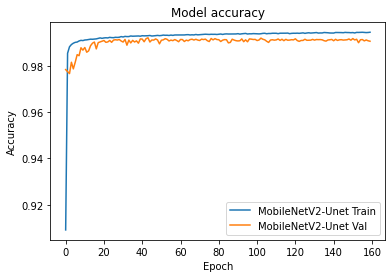

<Figure size 432x288 with 0 Axes>

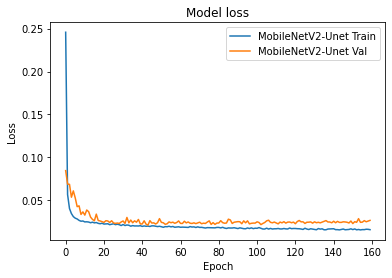

<Figure size 432x288 with 0 Axes>

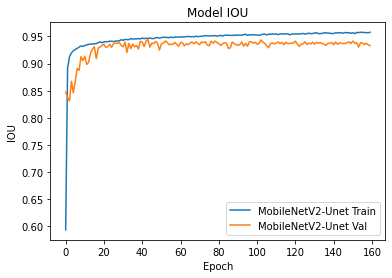

<Figure size 432x288 with 0 Axes>

In [0]:
plot_curves(unet_mobilenet_history,'MobileNetV2-Unet')

In [0]:
val_res,nice1_res,nice2_res = eval(mobinet_unet)

Combined [0.02603871561586857, 0.9907118678092957, 0.9343031644821167]
NICE-I [0.02630781941115856, 0.9905915260314941, 0.9179240465164185]
NICE-II [0.02497086115181446, 0.9909957647323608, 0.9347964525222778]


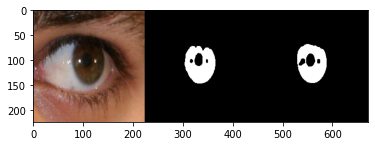

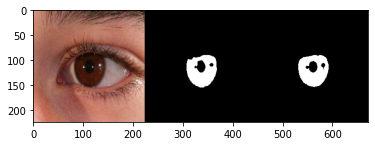

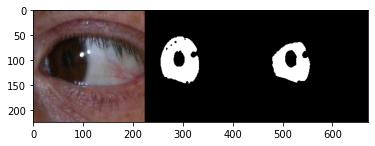

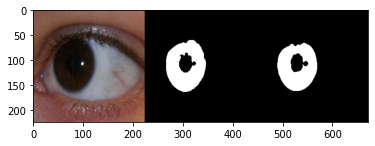

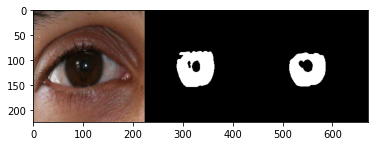

In [0]:
display_prediction(val_generator,mobinet_unet,5,reverse_mobilenet_prep)

Results are much better. We got a sparse categorical accuracy of 99.07% and IOU 93.43%. Also, we can see how the predictions are smoother and more accurate. But let's see it much clearer and compare them with some state-of-the-art results.

### NICE-1 Results
|Method   | E1(%)  | IOU(%)  |
|---|---|---|
| **Mobilenet-Unet**  | **0.94** | **91.79**  |
| FCN8  | 1.53  | 87.34  |
| Fast-FCN8 | 1.54   | 87.28  |

#### NICE-2 Results
|Method   | E1(%)  | IOU(%)  |
|---|---|---|
| **Mobilenet-Unet**  | **0.90** | **93.48**  |
| FCN8  | 1.53  | 89.34  |
| Fast-FCN8 | 1.59   | 89.23  |

#### NICE1+NICE2+MobBio Results
|Method   | E1(%)  | IOU(%)  |
|---|---|---|
| **Mobilenet-Unet**  | **0.93** | **93.43**  |
| FCN8  | 1.57  | 89.45  |
| Fast-FCN8 | 1.58   | 89.18  |


#### NICE-1 Benchmark
|Method   | E1(%)  | IOU(%)  |
|---|---|---|
| Liu et al.  | 0.90  | NA  |
| **Our Mobilenet-Unet**  | **0.94** | **91.79**  |
| Osorio et al.  |  1.13  | NA  |
| Zhao and Kumar | 1.21  |  NA |
| Tan et al. | 1.31  | NA  |
| **Our FCN8**   | **1.53**  | **87.34**  |
| **Our Fast-FCN8** | **1.54**   | **87.28**  |
| Tan and Kumar |  1.90 | NA  |

This data was obtained from the [Osorio et al.]('https://www.researchgate.net/publication/328701621_Visible_Wavelength_Iris_Segmentation_A_Multi-Class_Approach_using_Fully_Convolutional_Neuronal_Networks') and represent the evaluation for the NICE-1 database, there's no pubic records of IOU metric even when as we saw before is a more robust metric.

# Summary

Our modes got really good result just to be a 'one-run' training. We can keep improving by tuning our hyper-parameters, increasing the dataset or using more complex models.

We learned in this tutorial:
* How to load segmentation datasets and perform Data Agmentation on them
* How to reverse preprocessing function and restore our images
* How to create custom metrics and adapt metrics to work on sparse categorical labels
* How to add regularization to any model
* How to build some popular models and train them.
* How Depthwise Separable Convolution speed-up the training, keepig the learning power
* How to use learning curves to diagnose the training process
* How our models, even when we just trained them with standard hyperparameters achieved state-of-the-art results.

I hope this tutorial had been useful for you. Dont doubt and contact me if you need help with something. Thanks for reading, see you in the next one!


